<h1>Выявление случаев нечестной сдачи экзамена</h1>

<h2>Условия</h2>

<p>Экзамены проводятся в следующем формате: ученики приходят в специальный компьютерный класс, каждый садится за индивидуальный компьютер, открывает систему и начинает решать задачи.</p>
<p>Задания в системе выдаются по очереди: после того, как студент ответил, его ответ сохраняется и выдается следующее задание. К предыдущим заданиям вернуться нельзя. Также в экзамене нет вопросов с письменным ответом, можно только выбрать пункт из списка.</p>

<h2>Задача</h2>

<p>Проанализировать данные о проведении экзаменов и проинформировать коллег о подозрительном поведении учеников, если оно имело место быть.</p>

<h2>Данные</h2>

<h3>exam.csv</h3>
<p>В данном файле хранится общая информация о проведенных экзаменах.</p>
<ul>
    <li><b>id</b> - идентификатор экзамена.</li>
    <li><b>start_date</b> - время начала экзамена.</li>
    <li><b>tasks_cnt</b> - количество заданий в экзамене.</li>
</ul>

<h3> user_answer.csv</h3>
<p>Здесь собрана информация о показателях каждого ученика на экзамене.</p>
<ul>
    <li><b>exam_id</b> - идентификатор экзамена, который решал ученик.</li>
    <li><b>user_id</b> - идентификатор ученика в системе.</li>
    <li><b>task_ind</b> - номер задания, на которое ученик дал ответ.</li>
    <li><b>answer</b> -  ответ, который дал ученик на данное задание. Ответ представляется в виде целого числа — номера ответа, который выбрал ученик.</li>
    <li><b>verdict</b> - вердикт экзаменационной системы по ответу ученика. Равен «OK» в случае, если ученик дал правильный ответ, и равен «WA» в противном случае.</li>
    <li><b>time</b> - момент времени, в который ученик дал ответ на задание. Формат момента времени: %Y-%m-%d %H-%M-%S.</li>
</ul>

<h2>Гипотезы</h2>


<h3>1. Ученик списал будучи на экзамене</h3>
<p>Метрики для проверки гипотезы:</p>
<ul>
    <li>Доля одинаковых ответов</li>
</ul>

<h3>2. Ученик пришел с готовыми ответами</h3>
<p>Метрики для проверки гипотезы:</p>
<ul>
    <li>Время завершения экзамена</li>
</ul>

<h2>Предобработка данных</h2>

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns

In [2]:
# чтение файлов
exam = pd.read_csv("exam.csv")
user_answer = pd.read_csv("user_answer.csv")

In [3]:
exam

,id,start_date,tasks_cnt
0,1,2023-12-15 10:00:00,16
1,2,2023-12-20 10:00:00,4


In [4]:
user_answer.head()

,exam_id,user_id,task_ind,answer,verdict,time
0,1,98,1,1,OK,2023-12-15 10-22-51
1,1,98,2,0,WA,2023-12-15 11-16-21
2,1,98,3,1,OK,2023-12-15 11-28-44
3,1,98,4,0,WA,2023-12-15 11-54-32
4,1,98,5,0,WA,2023-12-15 12-30-11


<h3>user_answer</h3>

In [5]:
user_answer.isna().sum()

exam_id     0
user_id     0
task_ind    0
answer      0
verdict     0
time        0
dtype: int64

In [6]:
user_answer.dtypes

exam_id      int64
user_id      int64
task_ind     int64
answer       int64
verdict     object
time        object
dtype: object

In [7]:
user_answer['time'] = pd.to_datetime(user_answer['time'],
                                    format='%Y-%m-%d %H-%M-%S')

In [8]:
user_answer['time'].dtype

dtype('<M8[ns]')

<h3>exam</h3>

In [9]:
exam.dtypes

id             int64
start_date    object
tasks_cnt      int64
dtype: object

In [10]:
exam['start_date'] = pd.to_datetime(exam['start_date'],
                                   format='%Y-%m-%d %H:%M:%S')

In [11]:
exam['start_date'].dtype

dtype('<M8[ns]')

<h2>Вычисление метрик</h2>
<h3>Списывание у коллег</h3>
<p>Сравним ответы одного ученика с ответами другого ученика</p>

In [134]:
# делим датасет на 2 части: 1 вариант и 2 вариант
v1 = user_answer[user_answer['exam_id'] == 1]
v2 = user_answer[user_answer['exam_id'] == 2]

<h3>Вариант 1</h3>

In [135]:
v1

,exam_id,user_id,task_ind,answer,verdict,time
0,1,98,1,1,OK,2023-12-15 10:22:51
1,1,98,2,0,WA,2023-12-15 11:16:21
2,1,98,3,1,OK,2023-12-15 11:28:44
3,1,98,4,0,WA,2023-12-15 11:54:32
4,1,98,5,0,WA,2023-12-15 12:30:11
...,...,...,...,...,...,...
2235,1,89,12,3,OK,2023-12-15 10:03:36
2236,1,89,13,2,OK,2023-12-15 10:04:03
2237,1,89,14,0,OK,2023-12-15 10:04:04
2238,1,89,15,0,OK,2023-12-15 10:04:09


In [14]:
v1['user_id'].nunique()

140

<h4>Сравнение с другими учениками</h4>
<p>Для того, чтобы сравнить каждого ученика с каждым, присоединяем к датасету тот же самый датасет по параметру <b>task_ind</b></p>
<p>Таким образом, мы видимо ответы 2-х учеников на одинаковое задание</p>

In [15]:
user2user_v1 = v1.merge(v1, on='task_ind', suffixes=('_1', '_2'))

In [17]:
user2user_v1 = user2user_v1 \
    [user2user_v1['user_id_1'] != user2user_v1['user_id_2']]

In [22]:
user2user_v1 = user2user_v1 \
    [user2user_v1['answer_1'] == user2user_v1['answer_2']]

In [137]:
user2user_v1

,exam_id_1,user_id_1,task_ind,answer_1,verdict_1,time_1,exam_id_2,user_id_2,answer_2,verdict_2,time_2,key
1,1,98,1,1,OK,2023-12-15 10:22:51,1,49,1,OK,2023-12-15 10:52:48,"(49, 98)"
2,1,98,1,1,OK,2023-12-15 10:22:51,1,94,1,OK,2023-12-15 10:06:50,"(94, 98)"
3,1,98,1,1,OK,2023-12-15 10:22:51,1,118,1,OK,2023-12-15 10:10:38,"(98, 118)"
7,1,98,1,1,OK,2023-12-15 10:22:51,1,114,1,OK,2023-12-15 10:15:57,"(98, 114)"
14,1,98,1,1,OK,2023-12-15 10:22:51,1,4,1,OK,2023-12-15 10:09:07,"(4, 98)"
...,...,...,...,...,...,...,...,...,...,...,...,...
313593,1,89,16,1,OK,2023-12-15 10:04:15,1,77,1,OK,2023-12-15 10:18:51,"(77, 89)"
313594,1,89,16,1,OK,2023-12-15 10:04:15,1,29,1,OK,2023-12-15 11:25:33,"(29, 89)"
313595,1,89,16,1,OK,2023-12-15 10:04:15,1,17,1,OK,2023-12-15 11:30:11,"(17, 89)"
313596,1,89,16,1,OK,2023-12-15 10:04:15,1,137,1,OK,2023-12-15 10:50:08,"(89, 137)"


In [136]:
# доля вопросов, на которые у учеников совпадают ответы
user_similarity_frac = user2user_v1 \
    .groupby(['user_id_1', 'user_id_2'], as_index=False) \
    .agg({'verdict_1': lambda x: len(x) / 16}) \
    .rename(columns={'verdict_1': 'similarity'})

In [27]:
user_similarity_frac

,user_id_1,user_id_2,similarity
0,1,2,0.5625
1,1,3,0.5000
2,1,4,0.2500
3,1,5,0.5625
4,1,6,0.3125
...,...,...,...
19219,140,135,0.7500
19220,140,136,0.6250
19221,140,137,0.0625
19222,140,138,0.6250


In [140]:
user_similarity_frac

,user_id_1,user_id_2,similarity
0,1,2,0.5625
1,1,3,0.5000
2,1,4,0.2500
3,1,5,0.5625
4,1,6,0.3125
...,...,...,...
19219,140,135,0.7500
19220,140,136,0.6250
19221,140,137,0.0625
19222,140,138,0.6250


<Axes: xlabel='similarity', ylabel='Count'>

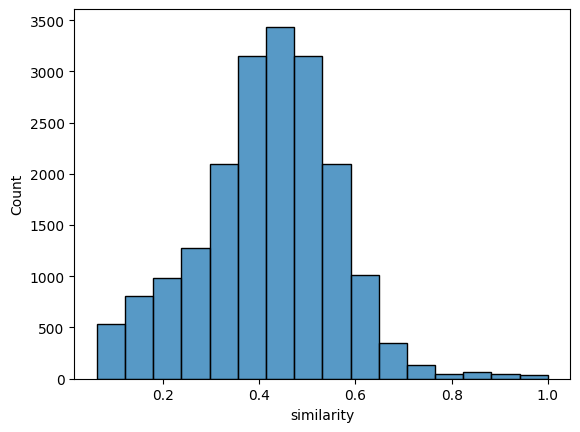

In [29]:
sns.histplot(user_similarity_frac['similarity'], bins=16)

<h4>Как видно из графика, у самое большое кол-во учеников имеют сходство в районе 0.4</h4>
<h4>Но также есть и те, у которых практически все ответы совпадают</h4>

In [31]:
user_similarity_frac['similarity'] \
    .value_counts() \
    .sort_index()

similarity
0.0625     532
0.1250     812
0.1875     986
0.2500    1274
0.3125    2094
0.3750    3152
0.4375    3436
0.5000    3152
0.5625    2096
0.6250    1016
0.6875     350
0.7500     134
0.8125      50
0.8750      62
0.9375      42
1.0000      36
Name: count, dtype: int64

<h4>Теперь посчитаем для каждого пользователя, насколько его работа похожа на другую работу (берем максимальное значение "похожести")</h4>

In [138]:
user_similarity = user_similarity_frac \
    .groupby('user_id_1', as_index=False) \
    .agg({'similarity': 'max'}) \
    .sort_values('similarity', ascending=False)

In [139]:
user_similarity

,user_id_1,similarity
0,1,1.0000
1,2,1.0000
8,9,1.0000
9,10,1.0000
57,58,1.0000
...,...,...
99,100,0.6250
133,134,0.6250
27,28,0.5625
120,121,0.5625


<Axes: xlabel='similarity', ylabel='Count'>

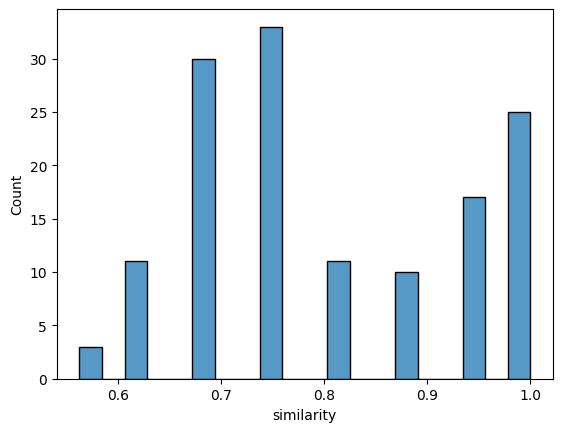

In [41]:
sns.histplot(user_similarity['similarity'], bins=20)

<h4>На графике видно, что после отметки 0.8 у значения <b>similarity</b> наблюдается подьем. Мы будем работать с пользователями, имеющими именно эти значения</h4>

In [43]:
user_similarity_frac.head()

,user_id_1,user_id_2,similarity
0,1,2,0.5625
1,1,3,0.5000
2,1,4,0.2500
3,1,5,0.5625
4,1,6,0.3125


In [143]:
# Выборка пользователей, у которых значение similarity выше 0.8
suspicious_users_v1 = user_similarity_frac[user_similarity_frac['similarity'] >= 0.8] \
    .copy(deep=True)

In [144]:
suspicious_users_v1['user_id_1'].nunique()

63

In [147]:
# Для каждого подозрительного пользователя рассчитываем долю правильных ответов
user_success_df = v1 \
    [v1['user_id'].isin(suspicious_users_v1['user_id_1'])] \
    .groupby('user_id', as_index=False) \
    .agg({'verdict': lambda x: (x == 'OK').sum() / len(x)}) \
    .rename(columns={'verdict': 'success_rate'})

In [148]:
user_success_df.head()

,user_id,success_rate
0,1,0.1875
1,2,0.1250
2,8,0.2500
3,9,0.1875
4,10,0.0625


In [52]:
user_success_df['success_rate'] \
    .value_counts() \
    .sort_index()

success_rate
0.0000     7
0.0625     8
0.1250     6
0.1875    11
0.2500     6
0.3125     4
0.3750     1
0.8125     1
0.8750     4
1.0000     4
Name: count, dtype: int64

In [152]:
# Итоговый список result_ids, в котором хранятся идентификаторы тех,
# у кого низкий success_rate, при этом высокая similarity

result_ids = set(suspicious_users_v1[suspicious_users_v1['user_id_1'].isin(
    user_success_df[user_success_df['success_rate'] < 0.8]['user_id']
)]['user_id_1'])

<h3>Теперь вычислим потенциальных списывальщиков, проверив, как быстро они написали и какой у них результат</h3>

In [155]:
# Меняем значения в колонке verdict на более удобный для нас тип данных
v1['verdict'] = v1['verdict'].apply(lambda x: 1 if x == 'OK' else 0)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_9192\959198354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v1['verdict'] = v1['verdict'].apply(lambda x: 1 if x == 'OK' else 0)


In [156]:
v1

,exam_id,user_id,task_ind,answer,verdict,time
0,1,98,1,1,0,2023-12-15 10:22:51
1,1,98,2,0,0,2023-12-15 11:16:21
2,1,98,3,1,0,2023-12-15 11:28:44
3,1,98,4,0,0,2023-12-15 11:54:32
4,1,98,5,0,0,2023-12-15 12:30:11
...,...,...,...,...,...,...
2235,1,89,12,3,0,2023-12-15 10:03:36
2236,1,89,13,2,0,2023-12-15 10:04:03
2237,1,89,14,0,0,2023-12-15 10:04:04
2238,1,89,15,0,0,2023-12-15 10:04:09


In [177]:
# Создаем таблицу, в котором видно время окончания экзамена и доля верных ответов

v1_seq = v1[['user_id', 'verdict', 'time']] \
    .groupby('user_id', as_index=False) \
    .agg({'verdict': 'mean', 'time': 'max'}) \
    .rename(columns={'verdict': 'success_rate', 'time': 'endtime'}) \
    .sort_values('success_rate', ascending=False)
v1_seq['endtime'] = v1_seq['endtime'].dt.hour - 10

<Axes: xlabel='endtime', ylabel='Count'>

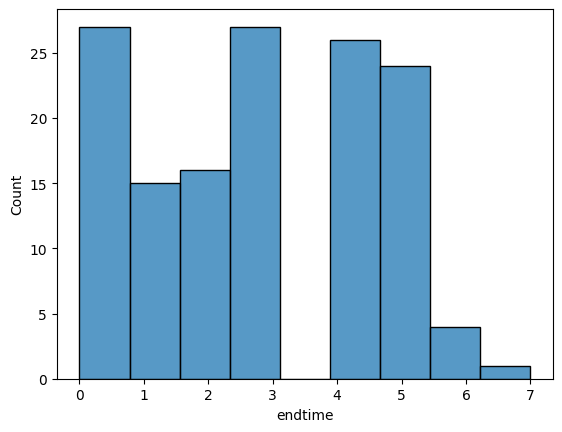

In [99]:
sns.histplot(v1_seq['endtime'])

<h4>На графике видно аномальное кол-во студентов, которые закончили экзамен менее чем за час</h4>
<p>Проверим их долю верных решений.</p>

In [163]:
strange_users_v1 = v1_seq[(v1_seq['endtime'] < 1)] \
    .sort_values('success_rate', ascending=False)

<Axes: xlabel='success_rate', ylabel='Count'>

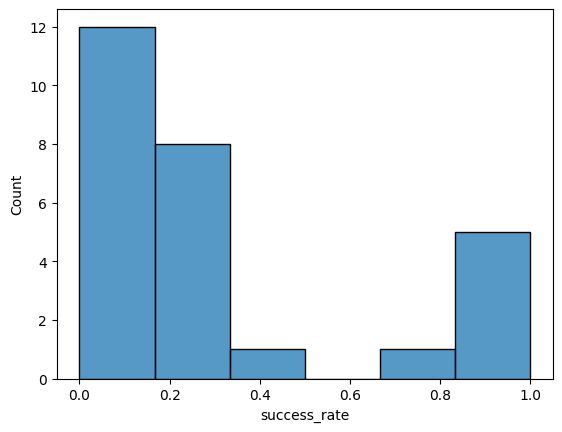

In [165]:
sns.histplot(strange_users_v1['success_rate'])

<h4>Из тех, кто завершил экзамен быстрее чем за час, присутствуют ученики, которые написали на высокие баллы. С высокой вероятностью они списывали.</h4>

In [167]:
result_ids_2 = list(
    strange_users_v1[strange_users_v1['success_rate'] > 0.6]['user_id']
)

In [173]:
suspicious_students_v1 = sorted(list(set(result_ids_2 + list(result_ids))))

<h3>Вариант 2</h3>
<p>Анализ результатов студентов, у которых 2 вариант, происходит аналогичмным образом.</p>

<h3>Списывание друг у друга</h3>

In [119]:
user2user_v2 = v2.merge(v2, on='task_ind', suffixes=('_1', '_2'))

In [124]:
user2user_v2 = user2user_v2[user2user_v2['user_id_1'] != user2user_v2['user_id_2']] \
    .sort_values(['user_id_1', 'user_id_2'], ascending=True)

In [126]:
user2user_v2 = user2user_v2[user2user_v2['answer_1'] == user2user_v2['answer_2']]

In [127]:
user2user_v2

,exam_id_1,user_id_1,task_ind,answer_1,verdict_1,time_1,exam_id_2,user_id_2,answer_2,verdict_2,time_2
711939,2,1,4,3,0,2023-12-20 10:30:37,2,2,3,0,2023-12-20 10:40:46
711326,2,1,3,2,0,2023-12-20 10:26:50,2,3,2,0,2023-12-20 10:16:40
711856,2,1,4,3,0,2023-12-20 10:30:37,2,3,3,0,2023-12-20 10:17:40
711587,2,1,3,2,0,2023-12-20 10:26:50,2,4,2,0,2023-12-20 10:37:18
711972,2,1,4,3,0,2023-12-20 10:30:37,2,5,3,0,2023-12-20 11:38:07
...,...,...,...,...,...,...,...,...,...,...,...
834204,2,530,2,0,1,2023-12-20 10:42:52,2,527,0,1,2023-12-20 10:55:14
834734,2,530,3,0,0,2023-12-20 10:43:47,2,527,0,0,2023-12-20 10:55:42
835264,2,530,4,3,0,2023-12-20 10:43:49,2,527,3,0,2023-12-20 10:55:58
834046,2,530,2,0,1,2023-12-20 10:42:52,2,529,0,1,2023-12-20 10:22:46


In [128]:
# сколько задач совпадает у пары учеников
# доля задач, на которые ученики дали одинаковые ответы
user_similarity_frac = user2user_v2 \
    .groupby(['user_id_1', 'user_id_2'], as_index=False) \
    .agg({'verdict_1': lambda x: len(x) / 16}) \
    .rename(columns={'verdict_1': 'similarity'})

In [129]:
user_similarity_frac

,user_id_1,user_id_2,similarity
0,1,2,0.0625
1,1,3,0.1250
2,1,4,0.0625
3,1,5,0.0625
4,1,6,0.1250
...,...,...,...
255115,530,524,0.1250
255116,530,525,0.0625
255117,530,526,0.0625
255118,530,527,0.2500


<Axes: xlabel='similarity', ylabel='Count'>

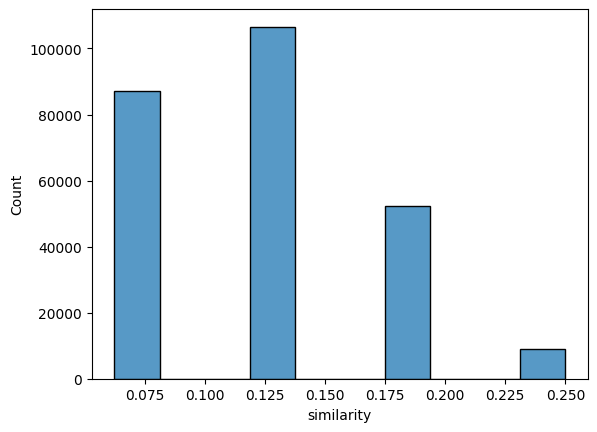

In [133]:
sns.histplot(user_similarity_frac['similarity'], bins=10)

<h4>Исходя из данных на графике, выбросов нет, поэтому сразу проверяем время написания и долю правильных ответов.</h4>

In [108]:
v2

,exam_id,user_id,task_ind,answer,verdict,time
2240,2,277,1,1,WA,2023-12-20 11:59:40
2241,2,277,2,2,WA,2023-12-20 12:01:32
2242,2,277,3,2,WA,2023-12-20 12:01:34
2243,2,277,4,1,WA,2023-12-20 12:02:41
2244,2,422,1,2,OK,2023-12-20 10:03:53
...,...,...,...,...,...,...
4355,2,210,4,3,WA,2023-12-20 11:11:24
4356,2,299,1,1,WA,2023-12-20 10:35:50
4357,2,299,2,0,OK,2023-12-20 10:37:59
4358,2,299,3,2,WA,2023-12-20 10:42:58


In [109]:
v2['verdict'] = v2['verdict'].apply(lambda x: 1 if x == 'OK' else 0)

C:\Users\Huawei\AppData\Local\Temp\ipykernel_9192\3132666435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v2['verdict'] = v2['verdict'].apply(lambda x: 1 if x == 'OK' else 0)


In [111]:
v2.head()

,exam_id,user_id,task_ind,answer,verdict,time
2240,2,277,1,1,0,2023-12-20 11:59:40
2241,2,277,2,2,0,2023-12-20 12:01:32
2242,2,277,3,2,0,2023-12-20 12:01:34
2243,2,277,4,1,0,2023-12-20 12:02:41
2244,2,422,1,2,1,2023-12-20 10:03:53


In [113]:
v2_seq = v2[['user_id', 'verdict', 'time']] \
    .groupby('user_id', as_index=False) \
    .agg({'verdict': 'mean', 'time': 'max'}) \
    .rename(columns={'verdict': 'success_rate', 'time': 'endtime'}) \
    .sort_values('success_rate', ascending=False)
v2_seq['endtime'] = v2_seq['endtime'].dt.hour - 10

<Axes: xlabel='endtime', ylabel='Count'>

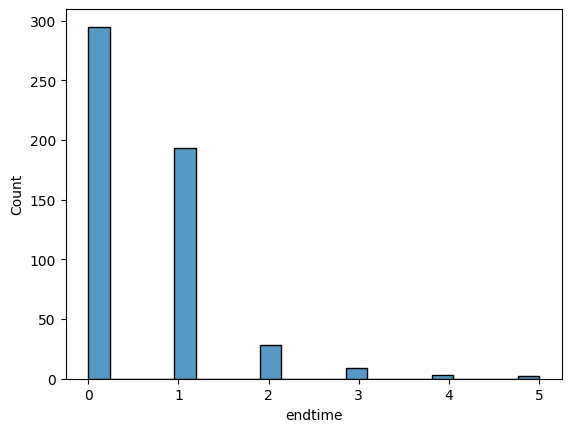

In [116]:
sns.histplot(v2_seq['endtime'])

In [178]:
strange_users_v2 = v2_seq[(v2_seq['endtime'] < 1.5)]

<Axes: xlabel='success_rate', ylabel='Count'>

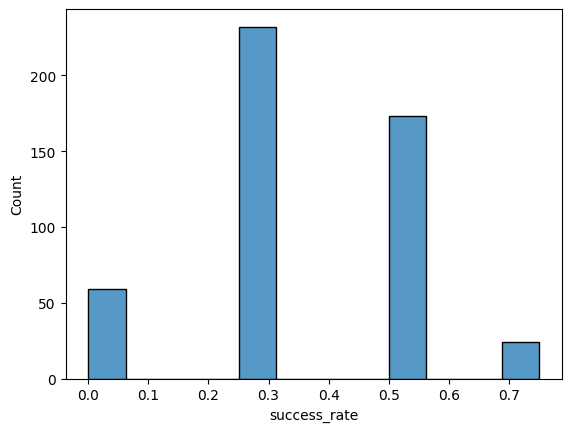

In [182]:
sns.histplot(strange_users_v2['success_rate'])

<h4>Будем считать тех учеников подозрительными, у которых <b>success_rate</b> больше 0.6</h4>

In [189]:
suspicious_students_v2 = sorted(list(set(strange_users_v2[strange_users_v2['success_rate'] > 0.6]['user_id'])))

In [190]:
suspicious_students_v2

[20,
 39,
 42,
 55,
 74,
 87,
 123,
 124,
 127,
 135,
 141,
 159,
 264,
 267,
 298,
 312,
 314,
 319,
 368,
 415,
 416,
 421,
 460,
 509]

<h1>Итоги исследования</h1>

In [196]:
# Соберем индентификаторы пользователей, которые подозреваются в списывании, в один словарь
suspicious_students = {
    'v1': suspicious_students_v1,
    'v2': suspicious_students_v2
}